# Методы оптимизации.
## Домашнее задание 2.
### Илья Игашов, 591 группа.

# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 

digits = load_digits()

In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

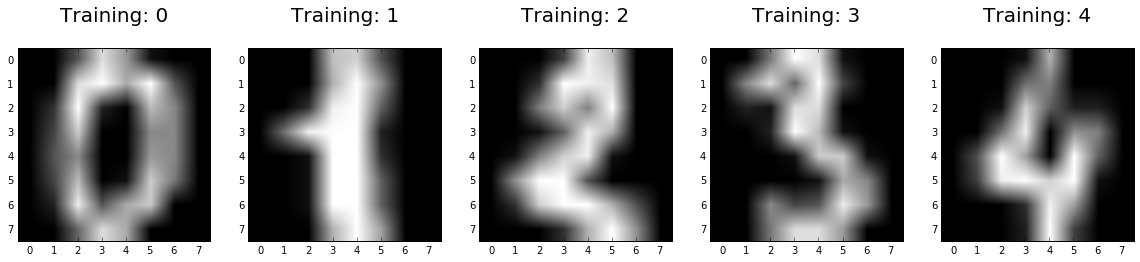

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

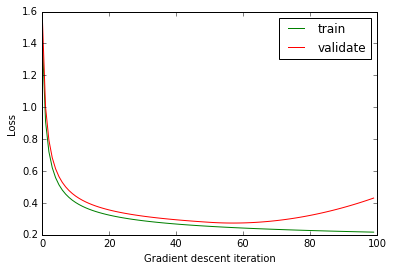

In [4]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [5]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
W \vec{x} + \vec{b}
$$


где $\vec{x}$ - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

Обозначим:

$\vec{L} = (l_!, l_1, \dots, l_{10})^T$ - вектор истинных вероятностей для данной картинки $\vec{x}$, т.е. на одном месте стоит 1, а все остальные - нули.

$\vec{y} = (y_1, y_2, \dots, y_{10})^T = softmax(W\vec{x}+\vec{b})$ - вектор вероятностей, которые предсказывает наша модель с заданными матрицей $W$ и вектором $b$.

Функция кросс-энтропии: 

$D(\vec{L}, \vec{y}) = -\sum_{i=1}^{10}l_i \log{y_i}$

Чтобы оценить качество нашей модели, посчитаем среднее значение функции $D$ на всех значениях выборки:

$loss = \frac{1}{N}\sum_{j}^{N} D(\vec{L^{(j)}}, \vec{y^{(j)}})$

In [6]:
def softmax(W,b,x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
    tmp = np.exp(np.dot(x,W.T)+b)
    return (tmp.T/tmp.sum(axis=1)).T
    
def loss (y, pred):
    entropy = np.array([
            (y_t * np.log(y_p)).sum() 
            for y_t, y_p in zip(y, pred)
        ])
    return (-1) * np.average(entropy)

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Наша задача - минимизировать функцию ошибки $loss$, которая определяется матрицей $W$ и вектором $\vec{b}$: $loss = loss(W, \vec{b})$. 

Будем минимизировать функцию $loss$ методом градиентного спуска, начиная с нулевой матрицы $W$ и нулевого вектора $\vec{b}$. 

Опять же рассмотрим функцию кросс-энтропии:

$$D(\vec{L}, \vec{y}) = -\sum_{i=1}^{10}l_i \log{y_i}, \ \ \text{где} \ \ y_i = \frac{e^{t_i}}{\sum_{k} e^{t_k}}, \ \  \vec{t} = (t_1, \dots, t_{10})^T = W\vec{x} + \vec{b}$$ 

Сначала возьмем градиент этой функции по $\vec{t}$:

$$\frac{\partial D}{\partial t_i} = -\sum_{k} l_k \frac{\partial \log y_k}{\partial t_i} = -\sum_{k} l_k \frac{1}{y_k} \frac{\partial y_k}{\partial t_i} = -l_i(1 - y_i) - \sum_{k \neq i} l_k \frac{1}{y_k}(-y_k y_i) = $$
$$= -l_i(1 - y_i) + \sum_{k \neq i} l_k y_i = -l_i + l_i y_i + \sum_{k \neq i} l_k y_i = y_i \sum_{k} l_k - l_i = y_i - l_i$$

Производные по $W$ и $\vec{b}$ находим как производные сложной функции: 
$$\frac{\partial D}{\partial \vec{b}} = \frac{\partial D}{\partial \vec{t}} \frac{\partial \vec{t}}{\partial \vec{b}} = (\vec{y} - \vec{l}) 1 = \vec{y} - \vec{l}$$

$$\frac{\partial D}{\partial W} = \frac{\partial D}{\partial \vec{t}} \frac{\partial \vec{t}}{\partial W} = (\vec{y} - \vec{l}) ^ T \vec{x}$$

Итак, мы нашли градиент для функции $D(\vec{L^{(j)}},\vec{y^{(j)}})$ (в первой функции - compute_gradients). Далее усредняем по всем $(\vec{L^{(j)}},\vec{y^{(j)}})$ (во второй функции - gradients).

In [7]:
# Рассчитываем градиент
# Производная по W - матрица размера 10x64, производная по b - вектор длины 10. 
# Для удобства усреднения в следующей функции, мы будем записывать градиент по b как последний (дополнительный) 
# столбец транспонированной матрицы производной по W. Получается, возвращаем мы одну матрицу размера 65x10.
def compute_gradients(out,x,y):
    derivative = out - y
    grad_b = np.array(derivative)
    grad_W = np.matrix(derivative).T @ np.matrix(x)
    grad = np.vstack((grad_W.T, grad_b))
    return grad
    

# Усредняем по всем точкам
# После усреднения мы разделяем нашу матрицу размера 65x10 на матрицу 10x64 и вектор и возвращаем их.
def gradients(W,b,x,y):
    sm = softmax(W,b,x)        
    e = [ compute_gradients(a,b,c) for a,b,c in zip(sm,x,y) ]
    mean_grad = np.mean(e, axis=0)
    return np.delete(mean_grad, -1, axis=0).T, mean_grad[-1]

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [8]:
eta = 100 # Постоянный шаг.
n_iter = 5000 # Количество итераций.

# Размер матрицы W - 10x64 (64 потому, что W действует на вектор длины 64, 
# а 10 - потому что в итоге должен получиться вектор длины 10);
# очевидно, длина вектора b равна 10
W = np.zeros((y_train.shape[1], x_train.shape[1]))
b = np.zeros(y_train.shape[1])

# Будем записывать потери на каждом шаге спуска.
losses_train=[]
losses_valid=[]

# Собственно, сам спуск.
for i in tqdm.tqdm(range(n_iter)):
    losses_train.append(loss(y_train, softmax(W,b,x_train)))
    losses_valid.append(loss(y_test, softmax(W,b,x_test)))
    delta_W, delta_b = gradients(W,b,x_train,y_train)
    W -= eta * delta_W
    b -= eta * delta_b

100%|██████████| 5000/5000 [05:32<00:00, 15.03it/s]


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

Loss minimum on testing data: 0.773591
Reached on 4999 step
Loss minimum on training data: 0.000065
Reached on 4999 step


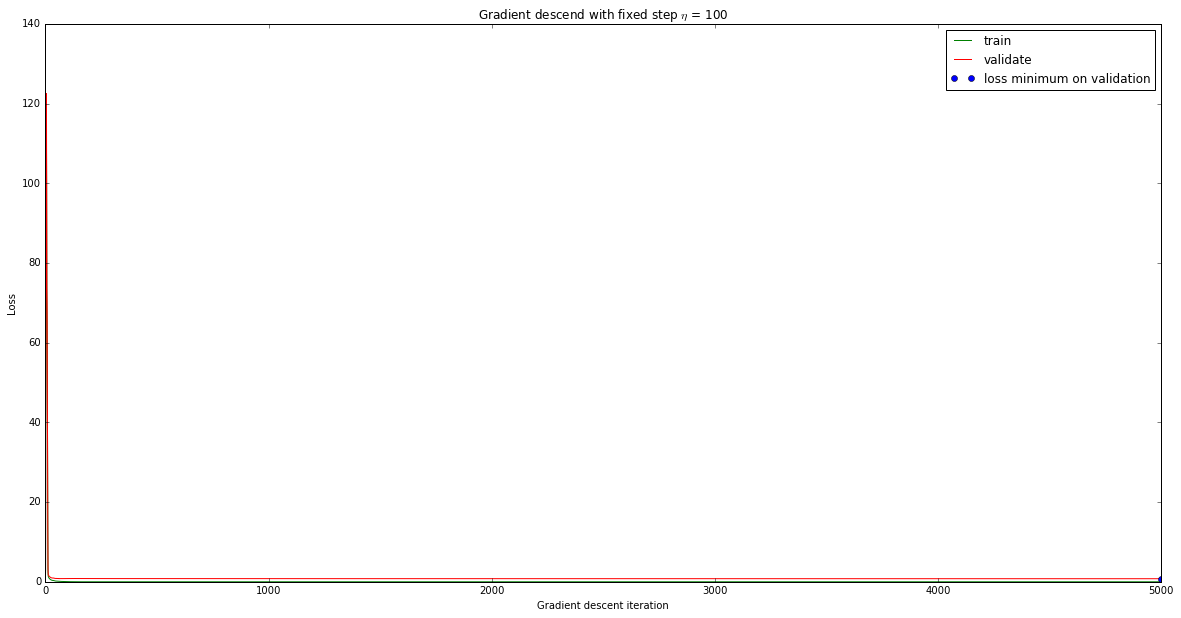

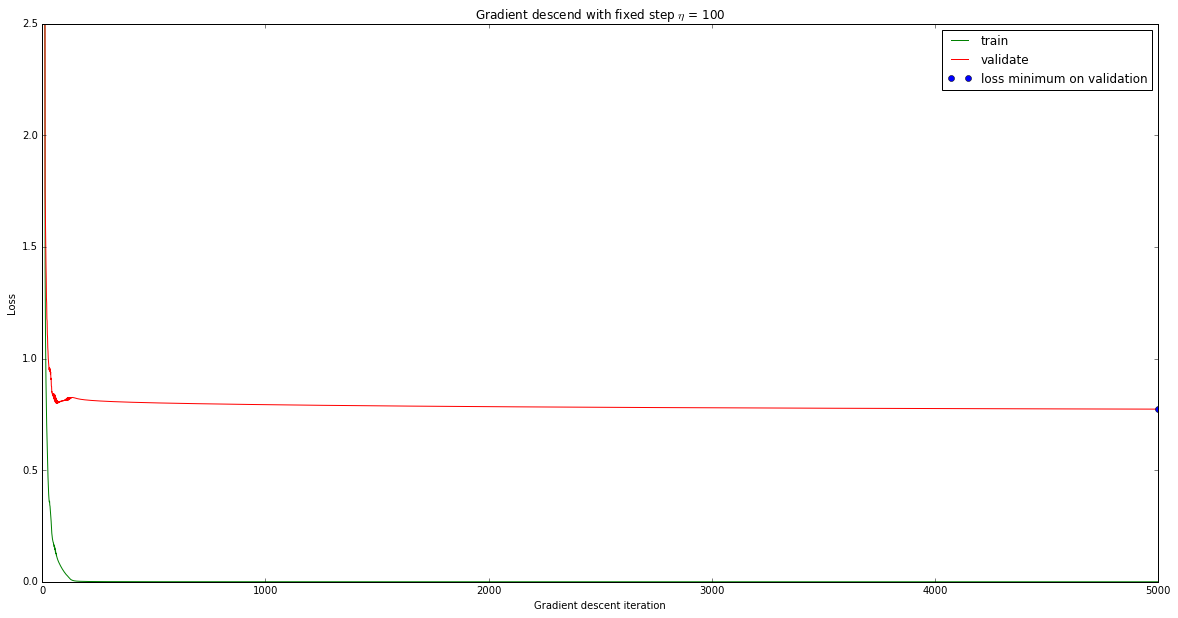

In [12]:
min_loss = np.min(losses_valid)
min_loss_idx = np.argmin(losses_valid)
min_loss_train = np.min(losses_train)
min_loss_idx_train = np.argmin(losses_train)

print("Loss minimum on testing data: %f" % min_loss)
print("Reached on %d step"% min_loss_idx)
print("Loss minimum on training data: %f" % min_loss_train)
print("Reached on %d step"% min_loss_idx_train)


plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.title(r'Gradient descend with fixed step $\eta$ = %d' % eta)
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Zoom
plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.ylim(0, 2.5)
plt.title(r'Gradient descend with fixed step $\eta$ = %d' % eta)
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

### Как мы видим, для постоянного шага 100 ошибки на обеих выборках падают монотонно и достигают минимума на последнем шаге.

### Картина меняется, если положить шаг равным 2.

In [13]:
eta = 2 # Постоянный шаг.
n_iter = 5000 # Количество итераций.

# Размер матрицы W - 10x64 (64 потому, что W действует на вектор длины 64, 
# а 10 - потому что в итоге должен получиться вектор длины 10);
# очевидно, длина вектора b равна 10
W = np.zeros((y_train.shape[1], x_train.shape[1]))
b = np.zeros(y_train.shape[1])

# Будем записывать потери на каждом шаге спуска.
losses_train=[]
losses_valid=[]

# Собственно, сам спуск.
for i in tqdm.tqdm(range(n_iter)):
    losses_train.append(loss(y_train, softmax(W,b,x_train)))
    losses_valid.append(loss(y_test, softmax(W,b,x_test)))
    delta_W, delta_b = gradients(W,b,x_train,y_train)
    W -= eta * delta_W
    b -= eta * delta_b

100%|██████████| 5000/5000 [05:32<00:00, 15.05it/s]


Loss minimum on testing data: 0.135736
Reached on 1919 step
Loss minimum on training data: 0.013880
Reached on 4999 step


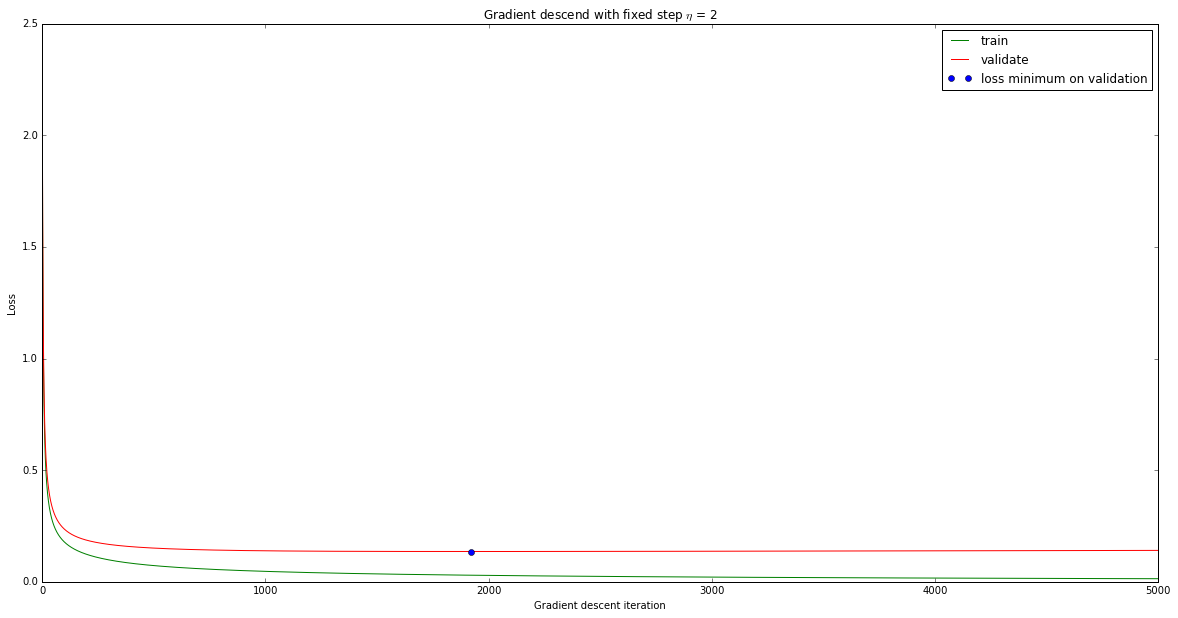

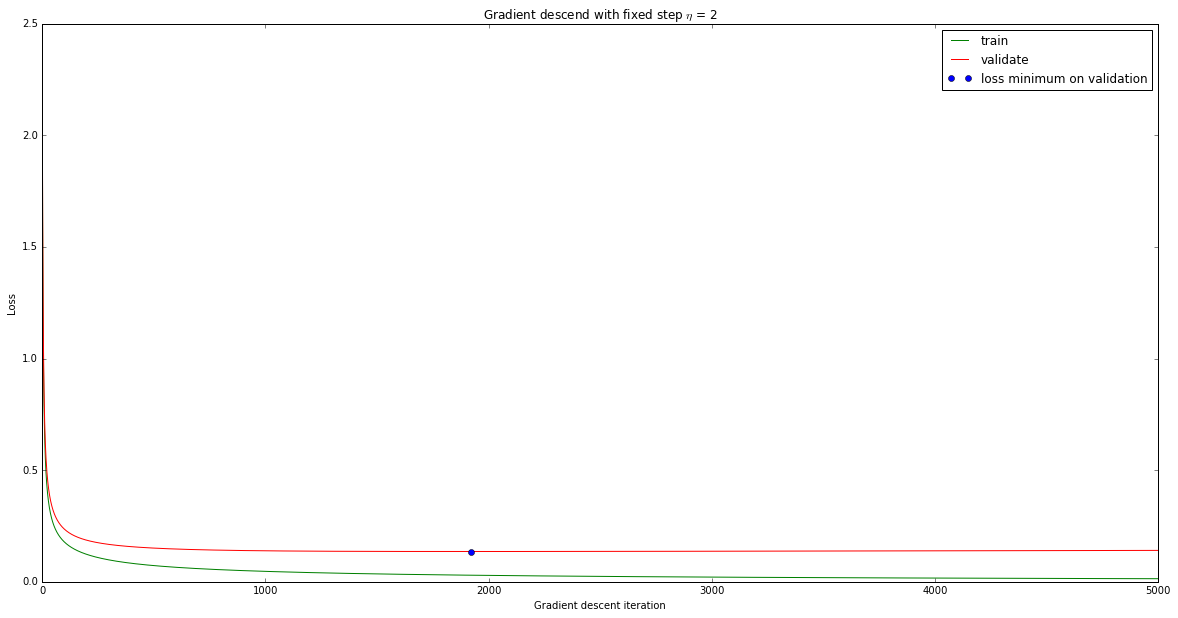

In [14]:
min_loss = np.min(losses_valid)
min_loss_idx = np.argmin(losses_valid)
min_loss_train = np.min(losses_train)
min_loss_idx_train = np.argmin(losses_train)

print("Loss minimum on testing data: %f" % min_loss)
print("Reached on %d step"% min_loss_idx)
print("Loss minimum on training data: %f" % min_loss_train)
print("Reached on %d step"% min_loss_idx_train)


plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.title(r'Gradient descend with fixed step $\eta$ = %d' % eta)
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Zoom
plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.ylim(0, 2.5)
plt.title(r'Gradient descend with fixed step $\eta$ = %d' % eta)
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

### Понятно, что для тренинговой выборки ошибка будет минимальна на последнем шаге всегда - в этом суть градиентного спуска. Однако при фиксированном шаге 2 мы видим, что на тестовой выборке ошибка достигает минимума на шаге 1919, а дальше она опять начинает возрастать - это как раз связанно с переобучением.

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [15]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    s = 100
    while loss(y, softmax(W - s * dW, b - s * db, x)) > \
    loss(y, softmax(W, b, x)) - alpha * s * np.linalg.norm(np.vstack((dW.T, db))) ** 2:
        s *= beta
    return s

In [16]:
n_iter = 5000
W = np.zeros((y_train.shape[1], x_train.shape[1]))
b = np.zeros(y_train.shape[1])
losses_train=[]
losses_valid=[]

for i in tqdm.tqdm(range(n_iter)):
    losses_train.append(loss(y_train, softmax(W,b,x_train)))
    losses_valid.append(loss(y_test, softmax(W,b,x_test)))
    delta_W, delta_b = gradients(W,b,x_train,y_train)
    eta = armijo(W, b, x_train, y_train, delta_W, delta_b)
    W -= eta * delta_W
    b -= eta * delta_b

100%|██████████| 5000/5000 [07:16<00:00, 11.46it/s]


Loss minimum on testing data: 0.135256
Reached on 160 step
Loss minimum on training data: 0.000393
Reached on 4999 step


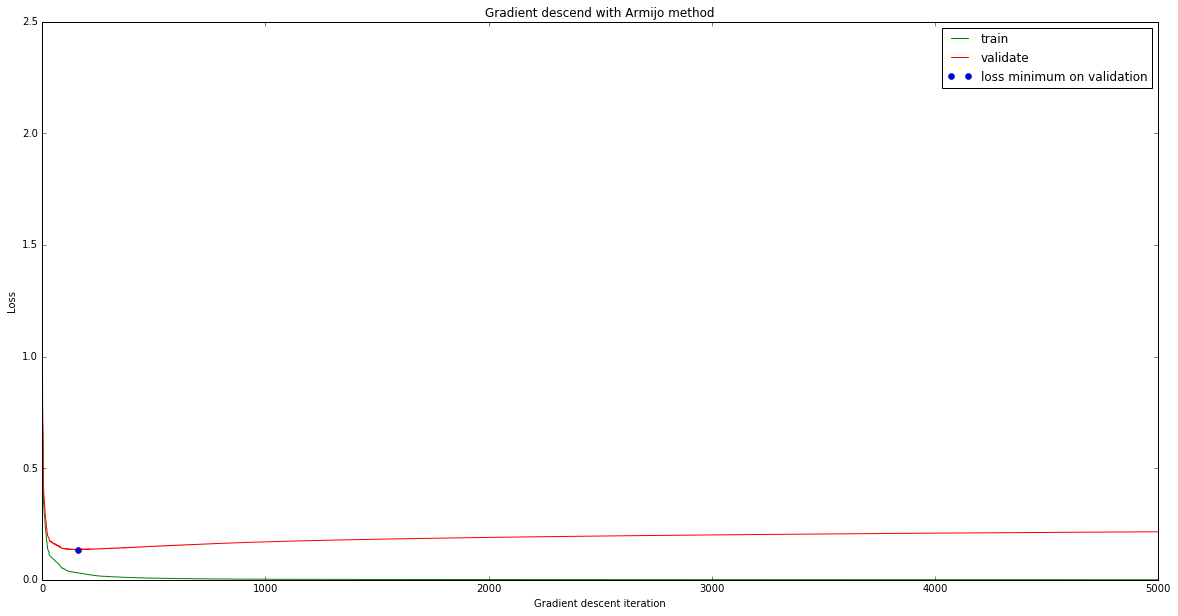

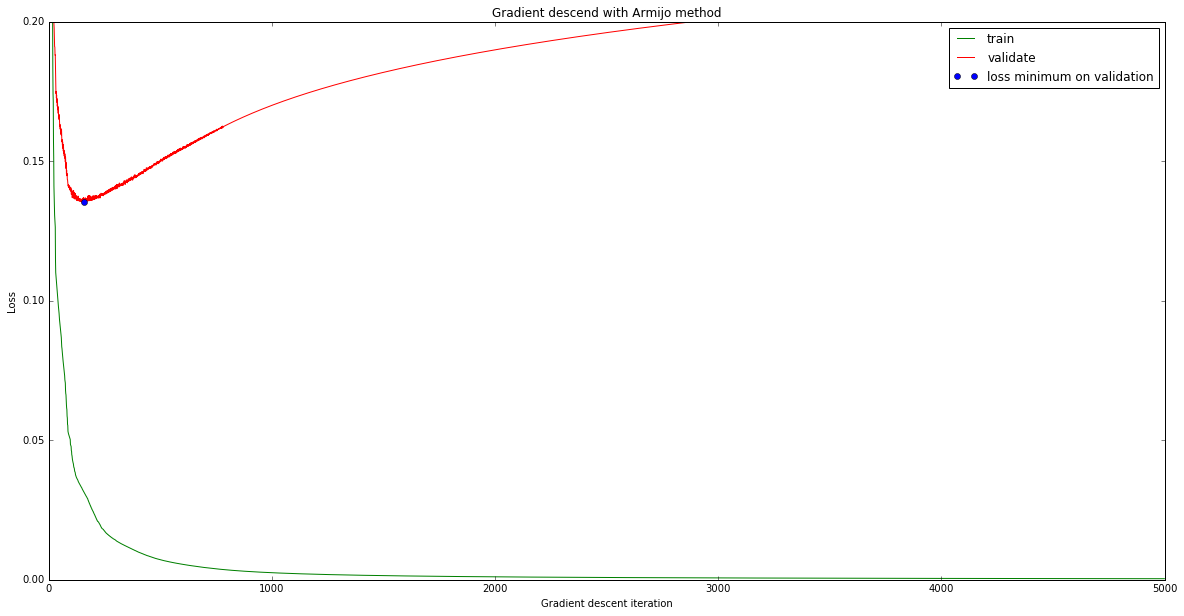

In [17]:
min_loss = np.min(losses_valid)
min_loss_idx = np.argmin(losses_valid)
min_loss_train = np.min(losses_train)
min_loss_idx_train = np.argmin(losses_train)

print("Loss minimum on testing data: %f" % min_loss)
print("Reached on %d step"% min_loss_idx)
print("Loss minimum on training data: %f" % min_loss_train)
print("Reached on %d step"% min_loss_idx_train)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.title(r'Gradient descend with Armijo method')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Zoom
plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.plot(np.arange(n_iter), losses_valid, color='red', label="validate")
plt.plot(min_loss_idx, min_loss, 'bo', label='loss minimum on validation')
plt.ylim(0, 0.2)
plt.title(r'Gradient descend with Armijo method')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.show()

### На тренинговой выборке ошибка, так же как и при постоянном шаге, монотонно убывает. Однако при использовании метода Армихо ее минимальное значение на порядок больше, чем при постоянном шаге 100. Значительно быстрее достигает своего минимума ошибка на тестовой выборке. При этом ее значение гораздо меньше, чем при фиксированном шаге 100. Можно сделать вывод, что метод Армихо быстрее ищет минимум функции, но, как показывает график, модель быстро переобучается.

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

In [18]:
# Выставляем нужные параметры
W = np.zeros((y_train.shape[1], x_train.shape[1]))
b = np.zeros(y_train.shape[1])
for i in tqdm.tqdm(range(min_loss_idx + 1)):
    delta_W, delta_b = gradients(W,b,x_train,y_train)
    eta = armijo(W, b, x_train, y_train, delta_W, delta_b)
    W -= eta * delta_W
    b -= eta * delta_b

100%|██████████| 161/161 [00:16<00:00,  9.47it/s]


In [19]:
# Заводим два массива: с номерами верно и неверно угаданных картинок
guessed = []
not_guessed = []

# Сравниваем предсказания с правильными ответами
y_pred = softmax(W,b,x_test)
for i in range(len(x_test)):
    true_class = np.argmax(y_test[i])
    pred_class = np.argmax(y_pred[i])
    if (true_class == pred_class):
        guessed.append(i)
    else:
        not_guessed.append(i)

print("Guessed ratio: %f" % (len(guessed) / len(x_test)))
print("Guessed ", len(guessed), " images of ", len(x_test))

Guessed ratio: 0.956229
Guessed  568  images of  594


# Примеры не угаданных картинок

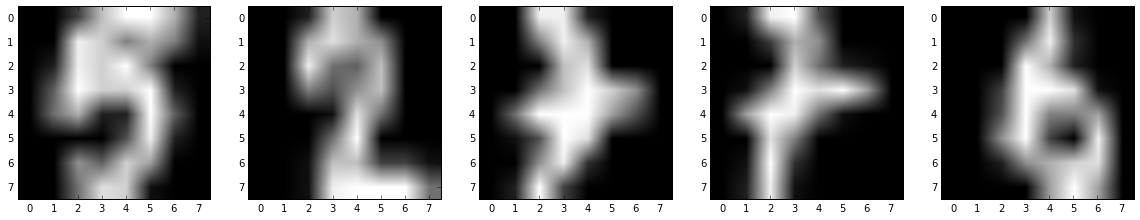

In [20]:
plt.figure(figsize=(20,4))
i = 0
for index in not_guessed[:5]:
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(x_test[index], (8,8)), cmap=plt.cm.gray)
    i += 1

# Примеры угаданных картинок

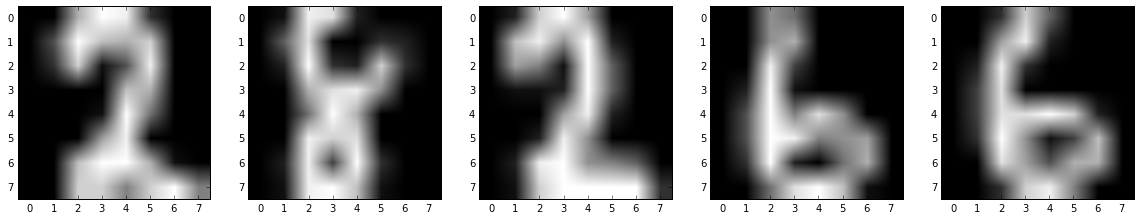

In [21]:
plt.figure(figsize=(20,4))
i = 0
for index in guessed[:5]:
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(x_test[index], (8,8)), cmap=plt.cm.gray)
    i += 1